## 0 Import Libraries

In [1]:
## Import libraries
import os
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage.measure import label, regionprops
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns


## 1 Data Preprocessing

### 1.1 Split Dataset

In [2]:
# Split the pneumonia images into bacteria and virus infection
def segregate_pneumonia_images(root_dir, output_dir):
    splits = ["train", "test", "val"]
    os.makedirs(output_dir, exist_ok=True)

    for split in splits:
        pneumonia_folder = os.path.join(root_dir, split, "pneumonia")
        if not os.path.isdir(pneumonia_folder):
            print(f"Directory not found: {pneumonia_folder}")
            continue
        # Define output folders for BACTERIA and VIRUS
        bacteria_output_folder = os.path.join(output_dir, split, "BACTERIA")
        virus_output_folder = os.path.join(output_dir, split, "VIRUS")
        os.makedirs(bacteria_output_folder, exist_ok=True)
        os.makedirs(virus_output_folder, exist_ok=True)

        image_files = [
            f
            for f in os.listdir(pneumonia_folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

        for image_file in image_files:
            source_path = os.path.join(pneumonia_folder, image_file)

            if "bacteria" in image_file.lower():
                target_path = os.path.join(bacteria_output_folder, image_file)
            elif "virus" in image_file.lower():
                target_path = os.path.join(virus_output_folder, image_file)
            else:
                print(f"Skipping unknown file type: {image_file}")
                continue

            # Copy image to the respective output folder
            shutil.copy(source_path, target_path)
            print(f"Copied {image_file} to {target_path}")

    # Randomly move 200 images from the train/virus folder to the val/virus folder
    train_virus_folder = os.path.join(output_dir, "train", "VIRUS")
    val_virus_folder = os.path.join(output_dir, "val", "VIRUS")
    os.makedirs(val_virus_folder, exist_ok=True)

    # Randomly move 192 images from the train/bacteria folder to the val/bacteria folder
    train_bacteria_folder = os.path.join(output_dir, "train", "BACTERIA")
    val_bacteria_folder = os.path.join(output_dir, "val", "BACTERIA")

    # Randomly move 192 images from the train/normal folder to the val/normal folder
    train_normal_folder = os.path.join(output_dir, "train", "NORMAL")
    val_normal_folder = os.path.join(output_dir, "val", "NORMAL")

    # Get all virus images in the train/virus folder
    virus_images = [
        f
        for f in os.listdir(train_virus_folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    bacteria_images = [
        f
        for f in os.listdir(train_bacteria_folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    normal_images = [
        f
        for f in os.listdir(train_normal_folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    # Randomly select 200 virus images from training dataset
    selected_virus_images = random.sample(virus_images, min(200, len(virus_images)))
    # Randomly select 192 bacterial images from training dataset
    selected_bacteria_images = random.sample(
        bacteria_images, min(192, len(bacteria_images))
    )
    # Randomly select 192 normal images from training dataset
    selected_normal_images = random.sample(
        normal_images, min(192, len(normal_images))
    )

    for image_file in selected_virus_images:
        source_path = os.path.join(train_virus_folder, image_file)
        target_path = os.path.join(val_virus_folder, image_file)

        # Move the selected image to the val/virus folder
        shutil.move(source_path, target_path)
        print(f"Moved {image_file} from {train_virus_folder} to {val_virus_folder}")

    for image_file in selected_bacteria_images:
        source_path = os.path.join(train_bacteria_folder, image_file)
        target_path = os.path.join(val_bacteria_folder, image_file)

        # Move the selected image to the val/virus folder
        shutil.move(source_path, target_path)
        print(
            f"Moved {image_file} from {train_bacteria_folder} to {val_bacteria_folder}"
        )

    for image_file in selected_normal_images:
        source_path = os.path.join(train_normal_folder, image_file)
        target_path = os.path.join(val_normal_folder, image_file)

        # Move the selected image to the val/virus folder
        shutil.move(source_path, target_path)
        print(
            f"Moved {image_file} from {train_normal_folder} to {val_normal_folder}"
        )

    # Remove all the "PNEUMONIA" folder in train, test, val
    for split in splits:
        pneumonia_folder = os.path.join(output_dir, split, "pneumonia")
        if os.path.isdir(pneumonia_folder):
            shutil.rmtree(pneumonia_folder)
            print(f"Removed {pneumonia_folder}")


# root_dir = "dataset/new_data"
# output_dir = "dataset/new_data"
# segregate_pneumonia_images(root_dir, output_dir)


### 1.2 Data Preprocessing Functions

In [3]:
def resize_image(image, target_size=(224, 224)):
    """
    Resizes an input image to the specified target size.

    Args:
        image (PIL Image or Torch Tensor): Input image to be resized.
        target_size (tuple): Desired output size (height, width).

    Returns:
        PIL Image: Resized image.
    """

    transform = transforms.Resize(target_size)
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)
    return transform(image)

def adaptive_masking(image, closing_kernel_size=(5, 5)):
    """
    Applies adaptive masking by removing the diaphragm from a grayscale image.

    Args:
        image (PIL Image, NumPy array, or Torch Tensor): Input grayscale image.
        closing_kernel_size (tuple): Size of the structuring element for morphological closing.

    Returns:
        torch.Tensor: Image with diaphragm removed as a tensor.
    """
    # Convert to NumPy array if the image is a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image.convert('L'))  # Ensure grayscale
    elif isinstance(image, torch.Tensor):
        # Convert to NumPy if the input is a tensor
        image = image.numpy()

    # If the image has a channel dimension (1, H, W), squeeze it to (H, W)
    if image.ndim == 3 and image.shape[0] == 1:
        image = np.squeeze(image, axis=0)

    # Step 1: Find max and min intensity values
    min_intensity = np.min(image)
    max_intensity = np.max(image)

    # Step 2: Calculate threshold using the formula: threshold = min + 0.9 * (max - min)
    threshold_value = min_intensity + 0.9 * (max_intensity - min_intensity)

    # Step 3: Apply binary thresholding
    _, binary_mask = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Step 4: Label connected regions and keep only the largest region
    labeled_mask = label(binary_mask)
    regions = regionprops(labeled_mask)
    if not regions:
        print("No regions found in the binary mask.")
        return torch.from_numpy(image).float().unsqueeze(0)

    # Identify the largest connected region
    largest_region = max(regions, key=lambda r: r.area)

    # Create a mask with only the largest region filled
    diaphragm_mask = np.zeros_like(binary_mask, dtype=np.uint8)
    diaphragm_mask[labeled_mask == largest_region.label] = 255

    # Step 5: Fill any holes in the diaphragm region
    diaphragm_mask = cv2.morphologyEx(diaphragm_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

    # Step 6: Apply morphological closing to smooth mask (remove small holes)
    kernel = np.ones(closing_kernel_size, np.uint8)
    diaphragm_mask = cv2.morphologyEx(diaphragm_mask, cv2.MORPH_CLOSE, kernel)

    # Step 7: Bitwise operation to remove diaphragm from the source image
    result_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(diaphragm_mask))

    equalized_pil_image = Image.fromarray(result_image)

    return equalized_pil_image

def histogram_equalization(image):
    """
    Performs histogram equalization on a grayscale image and returns a tensor.

    Args:
        image (PIL Image or Torch Tensor): Input grayscale image.

    Returns:
        torch.Tensor: Equalized image as a tensor.
    """

    # Convert the image to a NumPy array if it's a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image.convert('L'))  # Convert to grayscale
    elif isinstance(image, torch.Tensor):
        image = image.numpy()

    # Ensure the image is single-channel and np.uint8
    if image.ndim == 3 and image.shape[0] == 1:  # If shape is (1, H, W)
        image = image.squeeze(0)  # Remove the extra channel dimension
    elif image.ndim == 3 and image.shape[-1] == 1:  # If shape is (H, W, 1)
        image = image.squeeze(-1)

    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    equalized_image = cv2.equalizeHist(image)
    equalized_pil_image = Image.fromarray(equalized_image)
    # equalized_tensor = torch.from_numpy(equalized_image).float().unsqueeze(0)  # Add channel dimension for grayscale
    return equalized_pil_image

# It will segment the lung areas to isolate regions of interest, allowing you to focus on the lung lobes and filter out other structures.
# This will return a mask that segments the lung from the rest of the image
def otsu_threshold(image):
    """
    Applies Otsu's thresholding on a grayscale image.

    Args:
        image (PIL Image, NumPy array, or Torch Tensor): Input grayscale image.

    Returns:
        torch.Tensor: Binary image after applying Otsu's thresholding.
    """
    # Convert to NumPy array if the image is a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image.convert('L'))  # Ensure grayscale
    elif isinstance(image, torch.Tensor):
        # Convert to NumPy if the input is a tensor
        image = image.numpy()

    # If the image has a channel dimension (1, H, W), squeeze it to (H, W)
    if image.ndim == 3 and image.shape[0] == 1:
        image = np.squeeze(image, axis=0)

    # Ensure the image is in np.uint8 format for OpenCV compatibility
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.dtype == np.float32 else image.astype(np.uint8)

    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Convert back to a PyTorch tensor
    binary_tensor = torch.from_numpy(binary_image).float().unsqueeze(0)  # Add back channel dimension for grayscale

    return binary_tensor

# It uses the Scharr operator to detect the presence and clarity of lobe boundaries or other anatomical edges.
# Degraded or irregular edges might signal abnormalities related to pneumonia.
# This will return the original image with better edge emphasis.
def scharr_operator(image):
    """
    Applies Scharr's operator for edge detection on a grayscale image.

    Args:
        image (PIL Image, NumPy array, or Torch Tensor): Input grayscale image.

    Returns:
        torch.Tensor: Edge-detected image as a tensor.
    """
    # Convert to NumPy array if the image is a PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image.convert('L'))  # Ensure grayscale
    elif isinstance(image, torch.Tensor):
        # Convert to NumPy if the input is a tensor
        image = image.numpy()

    # If the image has a channel dimension (1, H, W), squeeze it to (H, W)
    if image.ndim == 3 and image.shape[0] == 1:
        image = np.squeeze(image, axis=0)

    # Apply Scharr operator in the x and y directions
    scharr_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
    scharr_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)

    # Calculate the gradient magnitude
    scharr_edges = cv2.magnitude(scharr_x, scharr_y)
    scharr_edges = np.clip(scharr_edges, 0, 255).astype(np.uint8)  # Clip and convert to uint8

    # Convert back to a PyTorch tensor
    edges_tensor = torch.from_numpy(scharr_edges).float().unsqueeze(0)  # Add back channel dimension for grayscale

    return edges_tensor


preprocess_types = {
    "adaptive_masking_equalized": [
        resize_image,
        adaptive_masking,
        histogram_equalization,
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.9, 1.1),
        ),
    ],
    "otsu": [
        resize_image,
        histogram_equalization,
        otsu_threshold,
    ],  # Act as additional feature for model training
    "scharr": [
        resize_image,
        histogram_equalization,
        scharr_operator,
    ],  # Act as additional feature for model training
}

### 1.3 Load Preprocessed Data (Google Colab)

In [4]:
# # Download new_data.zip from google drive
# # Note: This dataset is already splitted based on the pneumonia type (bacteria and virus) and the normal images
# # The dataset is also resplit into train, test, and validation folders
# # https://drive.google.com/file/d/1h3WmTxwDAKy2eRw0SCXcNVFdreuquRQN/view?usp=sharing

# import gdown
# import zipfile

# url = 'https://drive.google.com/uc?id=1h3WmTxwDAKy2eRw0SCXcNVFdreuquRQN'
# output = 'new_data.zip'
# gdown.download(url, output, quiet=False)

# # Unzip the new_data.zip file
# with zipfile.ZipFile("new_data.zip", "r") as zip_ref:
#     zip_ref.extractall("dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1h3WmTxwDAKy2eRw0SCXcNVFdreuquRQN
From (redirected): https://drive.google.com/uc?id=1h3WmTxwDAKy2eRw0SCXcNVFdreuquRQN&confirm=t&uuid=e67f8bc8-07f4-4759-a0cf-13f11fbceab3
To: /content/new_data.zip
100%|██████████| 1.23G/1.23G [00:11<00:00, 104MB/s]


In [5]:
# # Combined Transform Function (Adaptive Masking Equalized + Otsu + Scharr)
# def combined_transform(image):
#     features = []
#     for key, pipeline in preprocess_types.items():
#         # Apply pipeline sequentially
#         for func in pipeline:
#             image = func(image)

#         # Convert to grayscale, then to tensor
#         feature = transforms.Compose([
#             transforms.Lambda(lambda x: x.convert('L') if isinstance(x, Image.Image) else x),  # Grayscale
#             transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.ToTensor()(x)), # convert to tensor (To ensure torch.Size([1, 224, 224]))
#         ])(image)

#         features.append(feature)

#     # Concatenate all features along the channel dimension
#     return torch.cat(features, dim=0)

# # Dataset and DataLoader
# transform = transforms.Compose([
#     transforms.Lambda(combined_transform),  # Apply combined transform
# ])

# Adaptive Masking Equalized
transform = transforms.Compose(preprocess_types['adaptive_masking_equalized'] + [
    transforms.Lambda(lambda x: x.convert('L') if isinstance(x, Image.Image) else x), # convert to grayscale
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.ToTensor()(x)), # convert to tensor (To ensure torch.Size([1, 224, 224]))
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert single channel to RGB (3 channels)
])


root = 'dataset'
train_data = datasets.ImageFolder(root=f'{root}/train', transform=transform)
test_data = datasets.ImageFolder(root=f'{root}/test', transform=transform)
val_data = datasets.ImageFolder(root=f'{root}/val', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
for inputs, labels in train_loader:
    print(f"Input shape: {inputs.shape}")  # Should be [batch_size, channels, height, width]
    break


def printDatasetInfo(dataset):
    table = pd.DataFrame({
        'Index': dataset.class_to_idx.values(),
        'Class Name': dataset.class_to_idx.keys(),
        'Number of Samples': [dataset.targets.count(i) for i in dataset.class_to_idx.values()]
    })
    print(table.to_string(index=False))
    print("\n")

print(f"Train Dataset: {len(train_data)}")
printDatasetInfo(train_data)
print(f"Test Dataset: {len(test_data)}")
printDatasetInfo(test_data)
print(f"Validation Dataset: {len(val_data)}")
printDatasetInfo(val_data)

Input shape: torch.Size([32, 3, 224, 224])
Train Dataset: 4632
 Index Class Name  Number of Samples
     0   BACTERIA               2338
     1     NORMAL               1149
     2      VIRUS               1145


Test Dataset: 624
 Index Class Name  Number of Samples
     0   BACTERIA                242
     1     NORMAL                234
     2      VIRUS                148


Validation Dataset: 600
 Index Class Name  Number of Samples
     0   BACTERIA                200
     1     NORMAL                200
     2      VIRUS                200




## 2 Model Training

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """
    Trains and validates a model for a specified number of epochs.

    Parameters:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on ('cuda' or 'cpu')
        num_epochs: Number of epochs

    Returns:
        history: Dictionary containing training and validation loss and accuracy
    """
    model.to(device)
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predictions = torch.max(outputs, 1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader)
        val_acc = correct / total

        # Logging
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f} - Validation Acc: {val_acc:.4f}")
        print()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

In [8]:
# Load a pre-trained DenseNet model
# model = models.densenet161(pretrained=True)
# Load a pre-trained DenseNet model
url = 'https://drive.google.com/uc?id=1MuE97nSnKp5vAccigmtU6c95Gc9InES-'
output = 'densenet161.pth'
gdown.download(url, output, quiet=False)
model = torch.load("densenet161.pth")

# # Modify the classifier to match the number of classes in the dataset
# num_classes = len(train_data.classes)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the last 2 layers of the feature extractor
for param in model.features[-2:].parameters():
    param.requires_grad = True
# Unfreeze the classifier by keeping the original parameters of that layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 20

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Save the model
torch.save(model, "model.pth")

Downloading...
From (original): https://drive.google.com/uc?id=1MuE97nSnKp5vAccigmtU6c95Gc9InES-
From (redirected): https://drive.google.com/uc?id=1MuE97nSnKp5vAccigmtU6c95Gc9InES-&confirm=t&uuid=14819952-73ca-416d-b689-4c46c2770e16
To: /content/densenet161.pth
100%|██████████| 116M/116M [00:00<00:00, 180MB/s]
<ipython-input-8-c899262d1c67>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

Epoch 1/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Train Loss: 0.0553 - Train Acc: 0.9823
Validation Loss: 0.0972 - Validation Acc: 0.9817

Epoch 2/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Train Loss: 0.0542 - Train Acc: 0.9827
Validation Loss: 0.0929 - Validation Acc: 0.9817

Epoch 3/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Train Loss: 0.0381 - Train Acc: 0.9862
Validation Loss: 0.0871 - Validation Acc: 0.9817

Epoch 4/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Train Loss: 0.0447 - Train Acc: 0.9836
Validation Loss: 0.0906 - Validation Acc: 0.9817

Epoch 5/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Train Loss: 0.0429 - Train Acc: 0.9862
Validation Loss: 0.0817 - Validation Acc: 0.9833

Epoch 6/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Train Loss: 0.0361 - Train Acc: 0.9877
Validation Loss: 0.0893 - Validation Acc: 0.9817

Epoch 7/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Train Loss: 0.0369 - Train Acc: 0.9868
Validation Loss: 0.0898 - Validation Acc: 0.9817

Epoch 8/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Train Loss: 0.0359 - Train Acc: 0.9883
Validation Loss: 0.0800 - Validation Acc: 0.9817

Epoch 9/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Train Loss: 0.0357 - Train Acc: 0.9896
Validation Loss: 0.0840 - Validation Acc: 0.9850

Epoch 10/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Train Loss: 0.0404 - Train Acc: 0.9862
Validation Loss: 0.0926 - Validation Acc: 0.9817

Epoch 11/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Train Loss: 0.0391 - Train Acc: 0.9860
Validation Loss: 0.0802 - Validation Acc: 0.9817

Epoch 12/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Train Loss: 0.0401 - Train Acc: 0.9858
Validation Loss: 0.0817 - Validation Acc: 0.9850

Epoch 13/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Train Loss: 0.0402 - Train Acc: 0.9860
Validation Loss: 0.0784 - Validation Acc: 0.9850

Epoch 14/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Train Loss: 0.0329 - Train Acc: 0.9883
Validation Loss: 0.0798 - Validation Acc: 0.9833

Epoch 15/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.27it/s]


Train Loss: 0.0320 - Train Acc: 0.9883
Validation Loss: 0.0792 - Validation Acc: 0.9833

Epoch 16/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.27it/s]


Train Loss: 0.0318 - Train Acc: 0.9877
Validation Loss: 0.0827 - Validation Acc: 0.9850

Epoch 17/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Train Loss: 0.0345 - Train Acc: 0.9875
Validation Loss: 0.0846 - Validation Acc: 0.9817

Epoch 18/20


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Train Loss: 0.0429 - Train Acc: 0.9853
Validation Loss: 0.0924 - Validation Acc: 0.9800

Epoch 19/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Train Loss: 0.0328 - Train Acc: 0.9881
Validation Loss: 0.0798 - Validation Acc: 0.9833

Epoch 20/20


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Train Loss: 0.0328 - Train Acc: 0.9890
Validation Loss: 0.0793 - Validation Acc: 0.9867



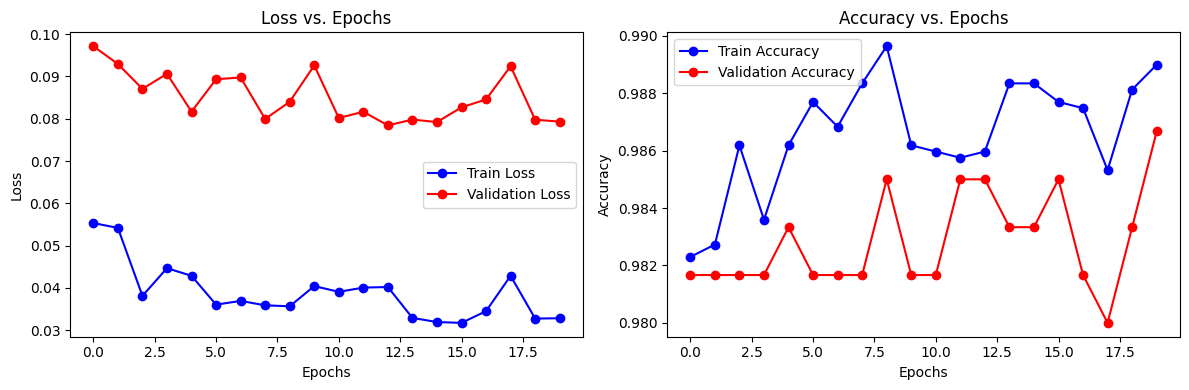

In [9]:
# Plot the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", color="blue", marker="o")
    plt.plot(history["val_loss"], label="Validation Loss", color="red", marker="o")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy", color="blue", marker="o")
    plt.plot(history["val_acc"], label="Validation Accuracy", color="red", marker="o")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Save the history in a CSV file
history_df = pd.DataFrame(history)
history_df.to_csv("history.csv", index=False)
plot_history(history)

## 3 Model Evaluation

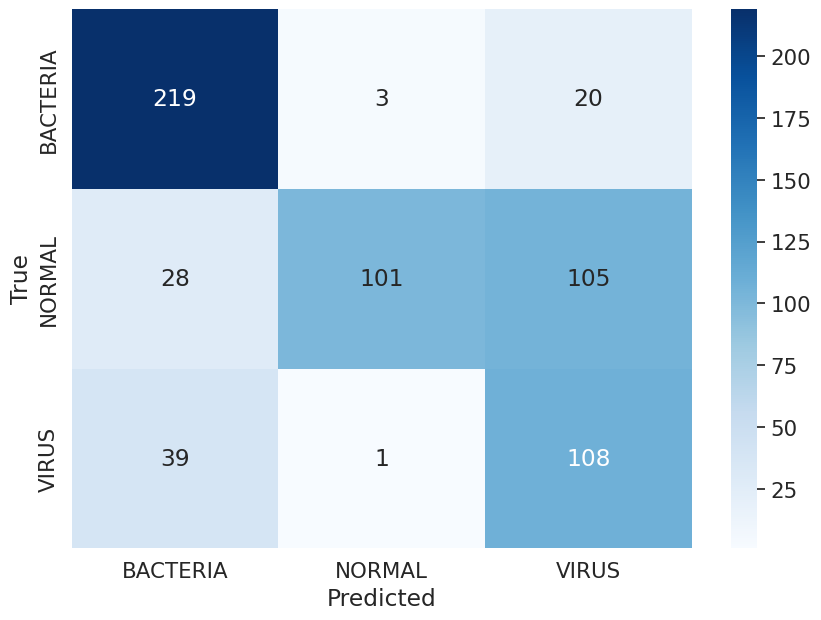



======== Classification Report ========

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       242
           1       0.96      0.43      0.60       234
           2       0.46      0.73      0.57       148

    accuracy                           0.69       624
   macro avg       0.73      0.69      0.66       624
weighted avg       0.77      0.69      0.68       624


======== Metrics ========
Accuracy           0.685897
Balanced Accuracy  0.688771
F1-Score           0.679630
Precision          0.767619
Recall             0.685897


In [10]:
model = torch.load('model.pth', weights_only=False, map_location=device)
# model = torch.load('DenseNet161_adaptive_masking_equalized.pth', weights_only=False, map_location=device)

# get the true and predicted labels
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# plot and save confusion matrix
cm = confusion_matrix(y_true, y_pred)
# replace class names using the class_to_idx mapping
class_names = [k for k, v in test_data.class_to_idx.items()]
plt.figure(figsize=(10, 7))
sns.set_theme(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('confusion_matrix.png')
plt.show()

# print and save classification report
print("\n\n======== Classification Report ========\n")
print(classification_report(y_true, y_pred))

# calculate metrics
print("\n======== Metrics ========")
acc = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# print in tabular format
results = pd.DataFrame({
    'Accuracy': [acc],
    'Balanced Accuracy': [balanced_acc],
    'F1-Score': [f1],
    'Precision': [precision],
    'Recall': [recall]
}).T
print(results.to_string(header=False))

0   BACTERIA      
1     NORMAL              
2      VIRUS

<Figure size 1000x500 with 0 Axes>

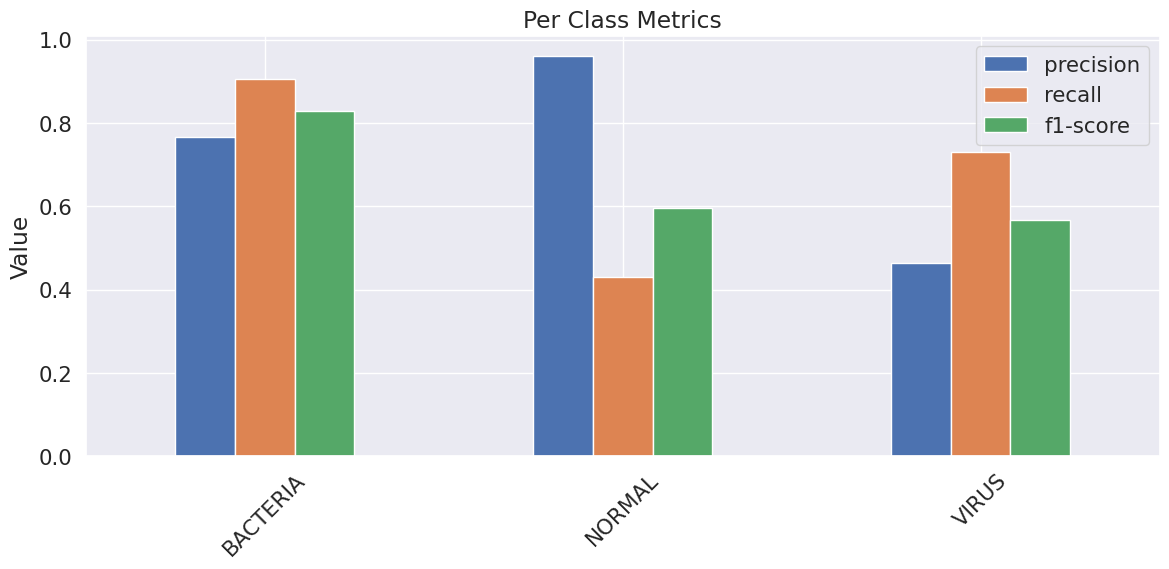

In [11]:
# Plot per class metrics
def plot_per_class_metrics(y_true, y_pred, class_names):
    # calculate metrics for each class
    metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df.iloc[:-3]  # exclude avg/total metrics
    metrics_df = metrics_df.drop(columns=['support'])

    # plot precision, recall, f1-score for each class
    plt.figure(figsize=(10, 5))
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.xticks(rotation=45)
    plt.title('Per Class Metrics')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

plot_per_class_metrics(y_true, y_pred, class_names)
